## Multi Layer Perceptron using TF

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

np.random.seed(1)
%matplotlib inline

/Users/tsungmin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1. Define functions

In [2]:
def one_hot_encode(x, n_class):
    """One Hot encoding
    
    parameter
    ---------
    x: array_like [n_sample]
    
    n_class: number of class
    
    return
    ------
    en_1hot: array_like [n_smaple, n_class] one hot encoding matrix
    """
    
    en_1hot = np.zeros([len(x), n_class])
    
    for idx, cat in enumerate(x):
        en_1hot[idx, cat] = 1

    return en_1hot


def forward(X, keep_prob, layers):
    
    layer_fmt = 'layer_{}'
    
    A = X
    for i in range(len(layers)):
        W, b = layers[layer_fmt.format(i + 1)]
        
        with tf.name_scope(layer_fmt.format(i + 1)):
            
            Z = tf.matmul(A, W) + b
            if i == len(layers) - 1:
                A = tf.nn.sigmoid(Z)
            else:
                A = tf.nn.relu(Z)
                A = tf.nn.dropout(A, keep_prob)
            
    return A


def build_model(X, y_onehot, keep_prob, layers):
        
    y_output = forward(X, keep_prob, layers)
    
    with tf.name_scope('loss'):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
            labels=y_onehot, logits=y_output)
    cost_op = tf.reduce_mean(cross_entropy)
    
    with tf.name_scope('pred'):
         pred_op = tf.argmax(tf.nn.softmax(y_output), axis=-1) 
    
    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(y_onehot, 1), tf.argmax(y_output, 1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
    acc_op = tf.reduce_mean(correct_prediction)
    
    return cost_op, pred_op, acc_op


def next_batch(X, y, batch_size, shuffle=True):
    """Get next batch data
    """
    
    n_sample = X.shape[0]
    n_batch = n_sample // batch_size
    n_batch = n_batch + 1 if (n_sample % n_batch) != 0 else n_batch 
    idx = np.array(range(n_sample))
    
    if shuffle:
        np.random.shuffle(idx)
        
    for b_idx in range(n_batch):
        start, end = b_idx * batch_size, (b_idx + 1) * batch_size
        if end >= n_sample:
            sample_idx = idx[start:]
        else:
            sample_idx = idx[start:end] 
        
        yield X[sample_idx, :], y[sample_idx, :]

## 2. Split data

In [3]:
def mnist_split_data(csv_file):
    """Split image and label from mnist csv data
    
    return
    ------
    X: array_like [n_sample, n_feature] mnist flat image
    y: array_like [n_sample] mnist image label
    """
    
    df = pd.read_csv(csv_file)
    
    X = df.iloc[:, 1:-1].values
    y = df.iloc[:, -1].values
    return X, y

In [4]:
X_train, y_train = mnist_split_data('ex5_train.csv')
X_test, y_test = mnist_split_data('ex5_test.csv')

n_class = len(np.unique(y_train))
y_train_en = one_hot_encode(y_train, n_class)
y_test_en = one_hot_encode(y_test, n_class)

## 3. Initialize parameters

In [5]:
def xavier_initializer(n_inputs, n_outputs):
    
    init_range = tf.sqrt(6.0 / (n_inputs + n_outputs))
    
    return tf.random_uniform([n_inputs, n_outputs], -init_range, init_range)


def weights_init(layer_dims):
    """weights initialize for layers
    
    parameter
    ---------
    layer_dims: list [n_input, n_output]
    
    return
    ------
    layers: dictionary of layer weights
    """
    
    layers = {}
    layer_fmt = 'layer_{}'
    var_fmt = '{var}{num}'
    
    for idx, (n_inputs, n_outputs) in enumerate(layer_dims):
        layer_name = layer_fmt.format(idx + 1)
        
        with tf.name_scope(layer_name):
            weight = tf.Variable(xavier_initializer(n_inputs, n_outputs), 
                             name=var_fmt.format(var='W', num=idx + 1))

            bias = tf.Variable(tf.zeros([n_outputs]), 
                           name=var_fmt.format(var='b', num=idx + 1))
    
        layers[layer_name] = (weight, bias)
        
    return layers

## 4. Neural Network model with 2 hidden layer

In [6]:
# layer_dims = [(400, 256),   # (n_input, n_output)
#               (256, 256),
#               (256, 128),
#               (128,  10)]

layer_dims = [(400, 256),   # (n_input, n_output)
              (256, 256),
              (256,  10)]

dropout_rate = 0.2

# prepare variables
layers = weights_init(layer_dims)
X = tf.placeholder(tf.float32, [None, 400], name='X')
y_onehot = tf.placeholder(tf.float32, [None, 10], name='y_onehot')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    
# build model
cost_op, pred_op, acc_op = build_model(X, y_onehot, keep_prob, layers)
train_op = tf.train.AdamOptimizer().minimize(cost_op)

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [7]:
# batch setting
epochs = 30
batch_size = 64

In [8]:
for epoch in range(epochs):
        
    costs = []    
    for X_batch, y_batch in next_batch(X_train, y_train_en, batch_size, shuffle=True):
    
        _, cost = sess.run([train_op, cost_op], 
                            feed_dict={ X: X_batch, y_onehot: y_batch, 
                                        keep_prob: 1 - dropout_rate})
        costs.append(cost)

    if (epoch + 1) % 10 == 0: 
        acc = sess.run(acc_op, feed_dict={ X: X_train, y_onehot: y_train_en, 
                                           keep_prob: 1.0})
        print('epoch:[{:3d}/{:3d}] avg cost: {:6.4f} acc: {:4.4f}'.
              format(epoch + 1, epochs, np.mean(costs), acc))

epoch:[ 10/ 30] avg cost: 1.5037 acc: 0.9743
epoch:[ 20/ 30] avg cost: 1.4799 acc: 0.9894
epoch:[ 30/ 30] avg cost: 1.4735 acc: 0.9917


## 5. Predictions

In [9]:
train_acc = sess.run(acc_op, feed_dict={ X: X_train, y_onehot: y_train_en, 
                                         keep_prob: 1.0})
print("train acc: {:4.4f}".format(train_acc))

test_acc = sess.run(acc_op, feed_dict={ X: X_test, y_onehot: y_test_en,
                                        keep_prob: 1.0})
print("test acc: {:4.4f}".format(test_acc))

sess.close()

train acc: 0.9917
test acc: 0.9527


## 6. Optimization

In [10]:
# layer_dims = [(400, 256),   # (n_input, n_output)
#               (256, 256),
#               (256, 128),
#               (128,  10)]

layer_dims = [(400, 256),   # (n_input, n_output)
              (256, 256),
              (256,  10)]

layers = weights_init(layer_dims)

X = tf.placeholder(tf.float32, [None, 400], name='X')
y_onehot = tf.placeholder(tf.float32, [None, 10], name='y_onehot')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    
cost_op, pred_op, acc_op = build_model(X, y_onehot, keep_prob, layers)
train_op = tf.train.AdamOptimizer().minimize(cost_op)

In [11]:
# batch setting
epochs = 30
batch_size = 64

In [12]:
dropout_rates = np.arange(0.1, 1.0, 0.1)
train_accs = []
test_accs = []

In [13]:
for dropout_rate in dropout_rates:
    
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        
        for epoch in range(epochs):

            costs = 0
            for X_batch, y_batch in next_batch(X_train, y_train_en, batch_size, shuffle=True):
                
                _ = sess.run(train_op, 
                             feed_dict={ X: X_batch, y_onehot: y_batch, 
                                         keep_prob: 1 - dropout_rate})

        train_acc = sess.run(acc_op, feed_dict={ X: X_train, y_onehot: y_train_en,
                                                 keep_prob: 1.0})
        test_acc = sess.run(acc_op, feed_dict={ X: X_test, y_onehot: y_test_en, 
                                                keep_prob: 1.0})
        
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        
        print('dropout rate: {:.2f} train acc: {:4.4f} test acc: {:4.4f}'.
              format(dropout_rate, train_acc, test_acc))

dropout rate: 0.10 train acc: 0.9914 test acc: 0.9473
dropout rate: 0.20 train acc: 0.9920 test acc: 0.9460
dropout rate: 0.30 train acc: 0.9906 test acc: 0.9433
dropout rate: 0.40 train acc: 0.9911 test acc: 0.9487
dropout rate: 0.50 train acc: 0.9877 test acc: 0.9433
dropout rate: 0.60 train acc: 0.9791 test acc: 0.9307
dropout rate: 0.70 train acc: 0.9680 test acc: 0.9293
dropout rate: 0.80 train acc: 0.9466 test acc: 0.9160
dropout rate: 0.90 train acc: 0.8414 test acc: 0.8220


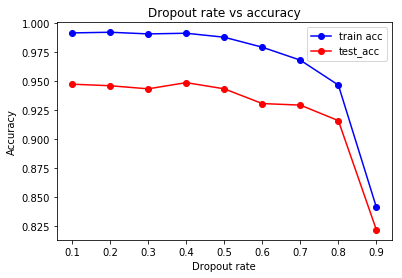

In [14]:
plt.plot(dropout_rates, train_accs, label='train acc', color='b', marker='o')
plt.plot(dropout_rates, test_accs, label='test_acc', color='r', marker='o')
plt.title('Dropout rate vs accuracy')
plt.xlabel('Dropout rate')
plt.ylabel('Accuracy')
plt.legend()